# Missing Block Cross Validation

Leave out a block of data and predict the withheld data. Models include cokriging, kriging,
and trend-only prediction

In [1]:
import sys

sys.path.insert(0, "../../source")


In [2]:
from copy import deepcopy
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm

import plot
import prediction
import validation


In [3]:
from dask.distributed import Client

# NOTE: update depending on which node is used
N_WORKERS = 84
client = Client(n_workers=N_WORKERS)


/home/jj829/miniconda3/envs/geostat/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33267 instead
  warnings.warn(
2023-05-04 14:19:20,325 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ag2pcusf', purging
2023-05-04 14:19:20,325 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-vpaxla5g', purging
2023-05-04 14:19:20,325 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-h3gt7fvg', purging
2023-05-04 14:19:20,325 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-791ps_vo', purging
2023-05-04 14:19:20,325 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ycf34idi', purging
2023-05-04 14:19:20,325 - distributed.diskutils

In [4]:
# number of nearest observations used in point predictions
NUM_LOCAL_VALUES = 150

# data selection
YEAR = 2021
MONTH = 10
# XCO2 months ahead of SIF
OFFSET = 1

year_month_str = f"{YEAR}0{MONTH}" if MONTH < 10 else f"{YEAR}{MONTH}"


In [5]:
month_xco2 = MONTH + OFFSET
date_sif = f"{YEAR}-{MONTH}-01"
date_xco2 = f"{YEAR}-{month_xco2}-01"

with xr.open_dataset(
    "../../data/intermediate/OCO2_005deg_monthly_north_america_with_basis.nc4"
) as ds:
    basis_vars = [x for x in list(ds.keys()) if x.startswith("B")]
    ds_sif = ds[["sif", "sif_var"] + basis_vars].sel(time=f"{YEAR}-{MONTH}").squeeze()


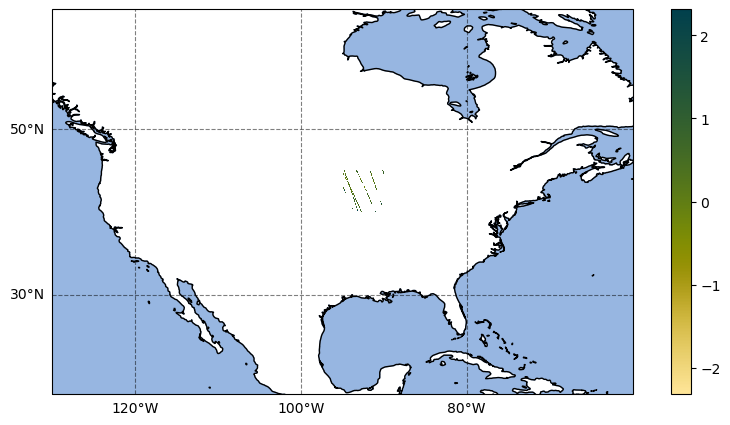

In [6]:
BLOCK_NAME = "b1"
block_conditions = (
    (ds_sif["lon"] > -95) & (ds_sif["lon"] < -90) & (ds_sif["lat"] > 40) & (ds_sif["lat"] < 45)
)
ds_test = ds_sif.where(block_conditions)

plot.plot_da(ds_test["sif"])


In [7]:
df_test = (
    ds_test.to_dataframe()
    .dropna(subset="sif")
    .reset_index()[["lat", "lon", "sif", "sif_var"] + basis_vars]
    .rename(columns={"sif": "data", "sif_var": "measurement_error"})
)
df_measurement_error = df_test.loc[:, ["lat", "lon", "measurement_error"]]
df_test = df_test.drop(columns="measurement_error")
ds_covariates = (
    df_test.set_index(["lat", "lon"]).to_xarray().drop_vars(["data", "B1", "B10", "B20"])
)
df_test = df_test.loc[:, ["lat", "lon", "data"]]
pcoords = df_test.loc[:, ["lat", "lon"]]
df_test.to_csv(f"../../data/intermediate/validation/{year_month_str}/df_test_{BLOCK_NAME}.csv")
df_test


,lat,lon,data
0,40.025,-92.825,0.574159
1,40.025,-92.775,0.443711
2,40.025,-91.125,0.791465
3,40.025,-91.075,1.380971
4,40.075,-93.225,0.567080
...,...,...,...
685,44.975,-93.375,0.696642
686,44.975,-91.775,0.496189
687,44.975,-91.725,0.318966
688,44.975,-90.275,0.199521


In [8]:
ds_covariates


<xarray.Dataset>
Dimensions:  (lat: 100, lon: 93)
Coordinates:
  * lat      (lat) float64 40.02 40.07 40.12 40.17 ... 44.82 44.87 44.92 44.97
  * lon      (lon) float64 -94.97 -94.92 -94.87 -94.82 ... -90.12 -90.07 -90.02
Data variables: (12/57)
    B2       (lat, lon) float64 nan nan nan nan nan nan ... 0.0 nan nan nan nan
    B3       (lat, lon) float64 nan nan nan nan nan nan ... 0.0 nan nan nan nan
    B4       (lat, lon) float64 nan nan nan nan nan nan ... 0.0 nan nan nan nan
    B5       (lat, lon) float64 nan nan nan nan nan nan ... 0.0 nan nan nan nan
    B6       (lat, lon) float64 nan nan nan nan nan nan ... 0.0 nan nan nan nan
    B7       (lat, lon) float64 nan nan nan nan nan nan ... 0.0 nan nan nan nan
    ...       ...
    B55      (lat, lon) float64 nan nan nan nan nan nan ... 0.0 nan nan nan nan
    B56      (lat, lon) float64 nan nan nan nan nan nan ... 0.0 nan nan nan nan
    B57      (lat, lon) float64 nan nan nan nan nan nan ... 0.0 nan nan nan nan
    B58      (lat, lon) float64 nan nan nan nan nan nan ... 0.0 nan nan nan nan
    B59      (lat, lon) float64 nan nan nan nan nan nan ... 0.0 nan nan nan nan
    B60      (lat, lon) float64 nan nan nan nan nan nan ... 0.0 nan nan nan nan

<AxesSubplot:ylabel='Count'>

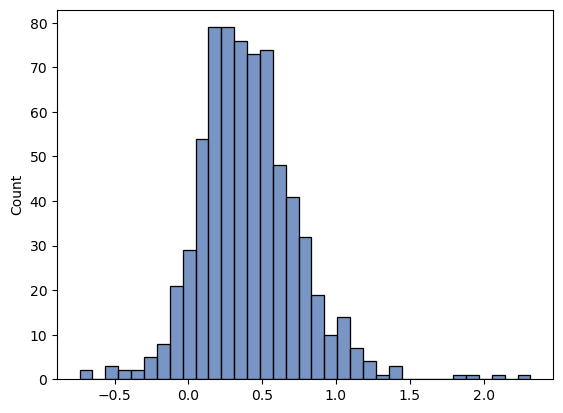

In [9]:
sns.histplot(df_test["data"].values)


## Cokriging

In [10]:
# Load multifield and model objects
with open(f"../../data/intermediate/models/{year_month_str}/fields.pickle", "rb") as f:
    mf = pickle.load(f)

with open(f"../../data/intermediate/models/{year_month_str}/model.pickle", "rb") as f:
    bivariate_matern = pickle.load(f)


In [11]:
# Make validation predictions
cokrige = prediction.Predictor(bivariate_matern, mf)
dict_cokrige = cokrige.cross_validation(
    0,
    pcoords,
    df_measurement_error,
    ds_covariates,
    num_local_values=NUM_LOCAL_VALUES,
)
ds_cokrige = dict_cokrige["ds"]
ds_cokrige


INFO | root:_compute_prediction_covariance_matrix:518 | Running predictive covariance
INFO | root:_compute_predictive_covariance_element:574 | Status: s = 0 ...
INFO | root:_compute_predictive_covariance_element:574 | Status: s = 200 ...
INFO | root:_compute_predictive_covariance_element:574 | Status: s = 300 ...
INFO | root:_compute_predictive_covariance_element:574 | Status: s = 400 ...
INFO | root:_compute_predictive_covariance_element:574 | Status: s = 500 ...
INFO | root:_compute_predictive_covariance_element:574 | Status: s = 600 ...
2023-05-04 14:23:56,577 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.22 GiB -- Worker memory limit: 5.99 GiB
2023-05-04 14:23:56,675 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This ma

<xarray.Dataset>
Dimensions:               (lat: 100, lon: 93)
Coordinates:
  * lat                   (lat) float64 40.02 40.07 40.12 ... 44.87 44.92 44.97
  * lon                   (lon) float64 -94.97 -94.92 -94.87 ... -90.07 -90.02
    time                  <U10 '2021-10-01'
Data variables: (12/66)
    residual_predictions  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    prediction_error      (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    validity_flag         (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    B2                    (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    B3                    (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    B4                    (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ...                    ...
    trend_surface         (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    measurement_error     (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    predictions           (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    mspe                  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    scaled_residuals      (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    trend_surface_mspe    (lat, lon) float64 0.0009026 0.0009026 ... 0.0009026
Attributes:
    timedeltas:        [0, 1]
    num_local_values:  150

In [12]:
# Save multivariate predictive distribution
pd.DataFrame(dict_cokrige["predictive_mean"]).to_csv(
    f"../../data/intermediate/validation/{year_month_str}/mean_cokriging_{BLOCK_NAME}.csv",
    header=None,
    index=None,
)

pd.DataFrame(dict_cokrige["predictive_covariance_matrix"]).to_csv(
    f"../../data/intermediate/validation/{year_month_str}/covariance_cokriging_{BLOCK_NAME}.csv",
    header=None,
    index=None,
)


In [13]:
# Prepare validation results
df_cokrige = (
    ds_cokrige.to_dataframe().reset_index()[["lat", "lon", "predictions", "mspe"]].dropna()
)

df_test_cokrige = validation.prepare_validation_results(
    df_cokrige,
    df_test,
    method="cokriging",
    month=year_month_str,
    region=BLOCK_NAME,
)

# Compute QQ-plot quantiles
quantiles_cokrige = sm.ProbPlot(df_test_cokrige["ratio"].values)
df_quantiles_cokrige = pd.DataFrame(
    dict(
        sample=quantiles_cokrige.sample_quantiles,
        theoretical=quantiles_cokrige.theoretical_quantiles,
        Method="Cokriging",
    )
)


## Kriging

In [14]:
client.close()


2023-05-04 14:25:03,011 - distributed.worker - WARNING - Heartbeat to scheduler failed
Traceback (most recent call last):
  File "/home/jj829/miniconda3/envs/geostat/lib/python3.9/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jj829/miniconda3/envs/geostat/lib/python3.9/site-packages/distributed/worker.py", line 1205, in heartbeat
    response = await retry_operation(
  File "/home/jj829/miniconda3/envs/geostat/lib/python3.9/site-packages/distributed/utils_comm.py", line 383, in retry_operation
    return await retry(
  File "/home/jj829/miniconda3/envs/geostat/lib/python3.9/site-packages/distributed/utils_comm.py", line 368, in retry
    return await coro()
  File "/home/jj829/miniconda3/envs/geostat/lib/python3.9/site-packages/distributed/core.py", l

In [15]:
client = Client(n_workers=N_WORKERS)


/home/jj829/miniconda3/envs/geostat/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34463 instead
  warnings.warn(


In [16]:
# Isolate SIF field only
mf_univariate = deepcopy(mf)
mf_univariate.fields = np.array([mf_univariate.fields[0]])
mf_univariate.n_procs = 1

# Load univariate model
with open(f"../../data/intermediate/models/{year_month_str}/univariate_model.pickle", "rb") as f:
    univariate_matern = pickle.load(f)


In [17]:
# Make validation predictions
krige = prediction.Predictor(univariate_matern, mf_univariate)
dict_krige = krige.cross_validation(
    0,
    pcoords,
    df_measurement_error,
    ds_covariates,
    num_local_values=NUM_LOCAL_VALUES,
)
ds_krige = dict_krige["ds"]
ds_krige


INFO | root:_compute_prediction_covariance_matrix:518 | Running predictive covariance
INFO | root:_compute_predictive_covariance_element:574 | Status: s = 0 ...
INFO | root:_compute_predictive_covariance_element:574 | Status: s = 200 ...
INFO | root:_compute_predictive_covariance_element:574 | Status: s = 300 ...
INFO | root:_compute_predictive_covariance_element:574 | Status: s = 400 ...
INFO | root:_compute_predictive_covariance_element:574 | Status: s = 500 ...
INFO | root:_compute_predictive_covariance_element:574 | Status: s = 600 ...
INFO | root:_compute_predictive_covariance_element:574 | Status: s = 100 ...


<xarray.Dataset>
Dimensions:               (lat: 100, lon: 93)
Coordinates:
  * lat                   (lat) float64 40.02 40.07 40.12 ... 44.87 44.92 44.97
  * lon                   (lon) float64 -94.97 -94.92 -94.87 ... -90.07 -90.02
    time                  <U10 '2021-10-01'
Data variables: (12/66)
    residual_predictions  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    prediction_error      (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    validity_flag         (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    B2                    (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    B3                    (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    B4                    (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ...                    ...
    trend_surface         (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    measurement_error     (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    predictions           (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    mspe                  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    scaled_residuals      (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    trend_surface_mspe    (lat, lon) float64 0.0009026 0.0009026 ... 0.0009026
Attributes:
    timedeltas:        [0, 1]
    num_local_values:  150

In [18]:
# Save multivariate predictive distribution
pd.DataFrame(dict_krige["predictive_mean"]).to_csv(
    f"../../data/intermediate/validation/{year_month_str}/mean_kriging_{BLOCK_NAME}.csv",
    header=None,
    index=None,
)

pd.DataFrame(dict_krige["predictive_covariance_matrix"]).to_csv(
    f"../../data/intermediate/validation/{year_month_str}/covariance_kriging_{BLOCK_NAME}.csv",
    header=None,
    index=None,
)


In [19]:
# Prepare validation results
df_krige = ds_krige.to_dataframe().reset_index()[["lat", "lon", "predictions", "mspe"]].dropna()

df_test_krige = validation.prepare_validation_results(
    df_krige,
    df_test,
    method="kriging",
    month=year_month_str,
    region=BLOCK_NAME,
)

# Compute QQ-plot quantiles
quantiles_krige = sm.ProbPlot(df_test_krige["ratio"].values)
df_quantiles_krige = pd.DataFrame(
    dict(
        sample=quantiles_krige.sample_quantiles,
        theoretical=quantiles_krige.theoretical_quantiles,
        Method="Kriging",
    )
)


## Trend-only

In [20]:
# Prepare validation results
df_trend = (
    ds_krige.to_dataframe()
    .reset_index()[["lat", "lon", "trend_surface", "trend_surface_mspe"]]
    .dropna()
    .rename(columns={"trend_surface": "predictions", "trend_surface_mspe": "mspe"})
)

df_test_trend = validation.prepare_validation_results(
    df_trend,
    df_test,
    method="Trend surface",
    month=year_month_str,
    region=BLOCK_NAME,
)

# Compute QQ-plot quantiles
quantiles_trend = sm.ProbPlot(df_test_trend["ratio"].values)
df_quantiles_trend = pd.DataFrame(
    dict(
        sample=quantiles_trend.sample_quantiles,
        theoretical=quantiles_trend.theoretical_quantiles,
        Method="Trend surface",
    )
)


In [21]:
# Save multivariate predictive distribution
df_test_trend["predictions"].to_csv(
    f"../../data/intermediate/validation/{year_month_str}/mean_trend_{BLOCK_NAME}.csv",
    header=None,
    index=None,
)
pd.DataFrame(np.diag(df_test_trend["mspe"].values)).to_csv(
    f"../../data/intermediate/validation/{year_month_str}/covariance_trend_{BLOCK_NAME}.csv",
    header=None,
    index=None,
)


## Collect and plot results

In [22]:
df_validation_results = pd.concat([df_test_trend, df_test_krige, df_test_cokrige], axis=0).reset_index(
    drop=True
)
df_validation_results.to_csv(
    f"../../data/intermediate/validation/{year_month_str}/validation_results_{BLOCK_NAME}.csv"
)
df_validation_results


,Method,Month,Region,lat,lon,data,predictions,mspe,difference,ratio,covered,INT,DSS
0,Trend surface,202110,b1,40.025,-92.825,0.574159,0.622820,0.088108,-0.048661,-0.163937,True,1.165597,-2.402322
1,Trend surface,202110,b1,40.025,-92.775,0.443711,0.622938,0.099333,-0.179226,-0.568663,True,1.237621,-1.985903
2,Trend surface,202110,b1,40.025,-91.125,0.791465,0.633862,0.114955,0.157603,0.464835,True,1.331394,-1.947139
3,Trend surface,202110,b1,40.025,-91.075,1.380971,0.634508,0.142509,0.746463,1.977365,False,1.693075,1.961625
4,Trend surface,202110,b1,40.075,-93.225,0.567080,0.616948,0.151571,-0.049867,-0.128088,True,1.528794,-1.870298
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,Cokriging,202110,b1,44.975,-93.375,0.696642,0.385652,0.101329,0.310990,0.976967,True,1.249996,-1.334919
2066,Cokriging,202110,b1,44.975,-91.775,0.496189,0.356895,0.087933,0.139294,0.469739,True,1.164443,-2.210522
2067,Cokriging,202110,b1,44.975,-91.725,0.318966,0.356254,0.105992,-0.037287,-0.114531,True,1.278436,-2.231270
2068,Cokriging,202110,b1,44.975,-90.275,0.199521,0.469772,0.098351,-0.270251,-0.861741,True,1.231493,-1.576612


In [23]:
df_quantiles = pd.concat(
    [df_quantiles_trend, df_quantiles_krige, df_quantiles_cokrige], axis=0
).reset_index(drop=True)
df_quantiles.to_csv(
    f"../../data/intermediate/validation/{year_month_str}/validation_ratio_quantiles_{BLOCK_NAME}.csv"
)

df_quantiles


,sample,theoretical,Method
0,-3.049512,-2.978741,Trend surface
1,-2.715288,-2.759516,Trend surface
2,-2.544685,-2.624287,Trend surface
3,-2.522952,-2.524769,Trend surface
4,-2.360538,-2.445335,Trend surface
...,...,...,...
2065,2.595830,2.445335,Cokriging
2066,2.739845,2.524769,Cokriging
2067,3.475498,2.624287,Cokriging
2068,3.813248,2.759516,Cokriging


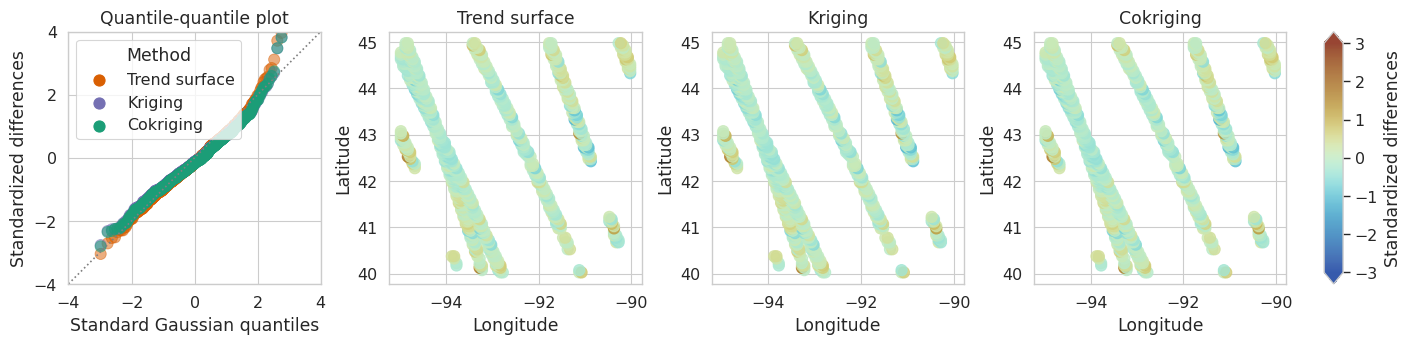

In [24]:
sns.set_theme(context="paper", style="whitegrid", font_scale=1.3, rc={"lines.markersize": 8})
qq_palette = ["#d95f02", "#7570b3", "#1b9e77"]
methods = ["Trend surface", "Kriging", "Cokriging"]

fig, axes = plt.subplots(1, 4, figsize=(14, 5), constrained_layout=True)

axes[0].axline(xy1=[0, 0], slope=1, linestyle="dotted", color="grey")
qq = sns.scatterplot(
    data=df_quantiles,
    x="theoretical",
    y="sample",
    hue="Method",
    hue_order=methods,
    palette=qq_palette,
    edgecolor="face",
    alpha=0.5,
    ax=axes[0],
)
qq.set(yticks=np.arange(-4, 6, 2))
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)
axes[0].set_aspect(aspect="equal")
axes[0].set_title("Quantile-quantile plot")
axes[0].set_xlabel("Standard Gaussian quantiles")
axes[0].set_ylabel("Standardized differences")

for i, method in enumerate(methods):
    df_group = df_validation_results.loc[df_validation_results["Method"] == method, :]
    field_diff = axes[i + 1].scatter(
        x=df_group["lon"],
        y=df_group["lat"],
        c=df_group["ratio"],
        alpha=0.8,
        cmap=cm.roma_r,
        vmin=-3,
        vmax=3,
    )
    axes[i + 1].set_aspect(aspect="equal")
    axes[i + 1].set_title(method)
    axes[i + 1].set_xlabel("Longitude")
    axes[i + 1].set_ylabel("Latitude")

fig.colorbar(
    field_diff,
    extend="both",
    label="Standardized differences",
    ax=axes[-1],
    cax=axes[-1].inset_axes([1.15, 0, 0.075, 1]),
)


In [25]:
fig.savefig(
    f"../../figures/cross_validation_{year_month_str}_{BLOCK_NAME}.pdf",
    dpi=300,
    bbox_inches="tight",
)
